In [299]:
#---imports---
import tensorflow as tf
import numpy as np
import os
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

In [300]:
#Function 3:
#--- Custom loss Function---
#Used by Function 4
#Input: disc_output - discriminator output (guess), batch_labels: one hot encoded batch labels (truth)
#Output: adversarial_loss: the lower the loss the worse the discriminator is at picking the correct batch
def loss_function_log(disc_output, batch_labels):
    #get Batch_size
    batch_size = batch_labels.shape[0]
    #Custom loss function: First calculate log(1-Confidence in correct batch)
    batch_labels = tf.cast(batch_labels, tf.float32)                # make sure floats match
    disc_output  = tf.cast(disc_output, tf.float32)                # make sure floats match

    # Element-wise multiplication followed by summation
    pred_confidence = (tf.reduce_sum(batch_labels * disc_output))/batch_size
    #Adversarial loss - make discriminator classify reconstructions as target labels
    adversarial_loss = -tf.math.log(1-pred_confidence)
    return adversarial_loss

def loss_function_uniform(disc_output, batch_labels):
    # The target is to have a uniform distribution around all classes
    num_classes = batch_labels.shape[1]
    target_labels = tf.ones_like(batch_labels) / num_classes
    adv_loss = tf.keras.losses.CategoricalCrossentropy()(target_labels, batch_labels)
    return adv_loss

#Function 4:
# ---Adverserial Training: Define Trainng function--- 
#Used by Function 5
#Define the autoencoder adversarial training function
#overriding the normal training function
"""
Implement later: improve own cross entropy function
"""
@tf.function 
def train_autoencoder_adversarial(gene_expression, batch_labels, autoencoder, discriminator, optimizer):
    """
    Train the autoencoder to fool the discriminator into classifying reconstructions as target classes.
    
    Args:
        gene_expression: Input gene_expression data
        batch_labels: One-hot encoded target batch labels to fool the discriminator
        encoder: Pretrained encoder model
        decoder: Pretrained decoder model
        discriminator: Pretrained discriminator model (frozen during this training)
        optimizer: Optimizer for the autoencoder
    """
    with tf.GradientTape() as tape:
        # CAll autoencoder to get reconstructed gene expression
        reconstructed_gene_expression = autoencoder(gene_expression)
        
        # Get discriminator output for reconstructed gene expression
        disc_output = discriminator(reconstructed_gene_expression)

        # Adversarial loss - the lower the loss the worse the discriminator is at picking the correct batch
        adverserial_loss = loss_function_log(batch_labels, disc_output)

        # Reconstruction loss - check much the data is transformed
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(gene_expression, reconstructed_gene_expression)
    
    # Get gradients and update autoencoder weights only
    gradients = tape.gradient(adverserial_loss, autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
    
    return adverserial_loss, reconstruction_loss

#Function 5: Adverserial Training loop
#---Adverserial Training: Create custom training loop---
#Input: Anndata Object, Epochs, Batch_size, Autoencoder, Discriminaotr
#Output: Autoencoder

def adversarial_training(adata, epochs, BATCHES, autoencoder, discriminator):
    # Initialize an empty history arrays
    adversarial_losses = []
    reconstruction_losses = []
    accuracies = []

    #Data preperation: adata to Tensorflow dataset
    #ADATA->NUMPY
    GENE_EXPRESSION = adata.X.toarray()
    #One-hot encoding the Batches
    encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
    BATCH_LABELS = encoder.fit_transform(adata.obs[['batchname_all']])
    #Combine NUMPY and One-hot encoded Batches in a Tensorflow dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((GENE_EXPRESSION, BATCH_LABELS))
    #Create training batches
    batch_size = BATCHES
    train_dataset = train_dataset.batch(batch_size)
    
    # Freeze the discriminator weights
    discriminator.trainable = False
    
    # Optimizer for the autoencoder
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
    
    # Training loop
    for epoch in range(epochs):

        dis_loss_avg = tf.keras.metrics.Mean()      #loss of the discriminator
        rec_loss_avg = tf.keras.metrics.Mean()      #loss of the autoencoder

        for batch in train_dataset:
            #Batch number
            gene_expression, batch_labels = batch
            
            # Train autoencoder
            adv_loss, rec_loss = train_autoencoder_adversarial(
                gene_expression, batch_labels, autoencoder, discriminator, optimizer
            )
            # Update adv loss
            dis_loss_avg.update_state(adv_loss)
            rec_loss_avg.update_state(rec_loss)

        
        # print epoch results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f" Adversarial Loss: {dis_loss_avg.result():.4f}, " +
              f" Reconstruction Loss: {rec_loss_avg.result():.4f}")
            
        #save history
        adversarial_losses.append(dis_loss_avg.result())
        reconstruction_losses.append(rec_loss_avg.result())
        accuracy = discriminator.evaluate(autoencoder(GENE_EXPRESSION), BATCH_LABELS, verbose=2)[1]
        accuracies.append(accuracy)

    #Create history DataFrame    
    history = pd.DataFrame({
        'adversarial_loss': adversarial_losses,
        'reconstruction_loss': reconstruction_losses,
        'accuracy': accuracies
        })
    return history, autoencoder

In [301]:
#---load data and Neuronal Networks---
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'data')
#Name of data set
dataset_name = 'large_atac_gene_activity'
# read dataset into an anndata object:  Category - Cells of the brain
inPath = os.path.join(base_path, f"{dataset_name}.h5ad")
adata = sc.read(inPath)

#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'src', 'models', 'saved_models')
#Name of autoencoder
dataset_name = 'autoencoder_mselossfunction'
# load autoencoder
inPath = os.path.join(base_path, f"{dataset_name}.keras")
autoencoder = tf.keras.models.load_model(inPath)

#Name of discriminator
dataset_name = 'discriminator_pretrained'
# load discriminator
inPath = os.path.join(base_path, f"{dataset_name}.keras")
discriminator = tf.keras.models.load_model(inPath)


In [302]:
#---look at data---
#Data preperation: adata to Tensorflow dataset
#ADATA->NUMPY
GENE_EXPRESSION = adata.X.toarray()
#One-hot encoding the Batches
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
BATCH_LABELS = encoder.fit_transform(adata.obs[['batchname_all']])
#Combine NUMPY and One-hot encoded Batches in a Tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((GENE_EXPRESSION, BATCH_LABELS))
#Batch the data set
train_dataset = train_dataset.batch(30)

# Create an iterator from the dataset
dataset_iterator = iter(train_dataset)

# Get the first batch
batch = next(dataset_iterator)

In [303]:
#Check discriminator
print("Accuracy on base data:")
discriminator.evaluate(GENE_EXPRESSION, BATCH_LABELS, verbose=2)
print("Accuracy on autoencoded data:")
discriminator.evaluate(autoencoder(GENE_EXPRESSION), BATCH_LABELS, verbose=2)

Accuracy on base data:
2651/2651 - 3s - 1ms/step - accuracy: 0.3211 - loss: 1.8420
Accuracy on autoencoded data:
2651/2651 - 3s - 964us/step - accuracy: 0.3220 - loss: 1.8220


[1.8220343589782715, 0.3220379054546356]

In [304]:
#---Training---
# Run the training
epochs = 10
history, autoencoder = adversarial_training(adata, epochs, 100, autoencoder, discriminator)

Epoch 1/10
 Adversarial Loss: 0.2571,  Reconstruction Loss: 0.0663
2651/2651 - 2s - 938us/step - accuracy: 0.3033 - loss: 1.8603
Epoch 2/10
 Adversarial Loss: 0.2251,  Reconstruction Loss: 0.0669
2651/2651 - 3s - 1ms/step - accuracy: 0.2386 - loss: 2.1156
Epoch 3/10
 Adversarial Loss: 0.1424,  Reconstruction Loss: 0.0695
2651/2651 - 3s - 990us/step - accuracy: 0.1006 - loss: 3.8412
Epoch 4/10
 Adversarial Loss: 0.0891,  Reconstruction Loss: 0.0737
2651/2651 - 3s - 1ms/step - accuracy: 0.0782 - loss: 5.0985
Epoch 5/10
 Adversarial Loss: 0.0756,  Reconstruction Loss: 0.0776
2651/2651 - 3s - 964us/step - accuracy: 0.0728 - loss: 5.8802
Epoch 6/10
 Adversarial Loss: 0.0693,  Reconstruction Loss: 0.0813
2651/2651 - 3s - 956us/step - accuracy: 0.0659 - loss: 6.4547
Epoch 7/10
 Adversarial Loss: 0.0653,  Reconstruction Loss: 0.0852
2651/2651 - 3s - 1ms/step - accuracy: 0.0579 - loss: 6.9128
Epoch 8/10
 Adversarial Loss: 0.0624,  Reconstruction Loss: 0.0891
2651/2651 - 2s - 925us/step - accura

<function matplotlib.pyplot.show(close=None, block=None)>

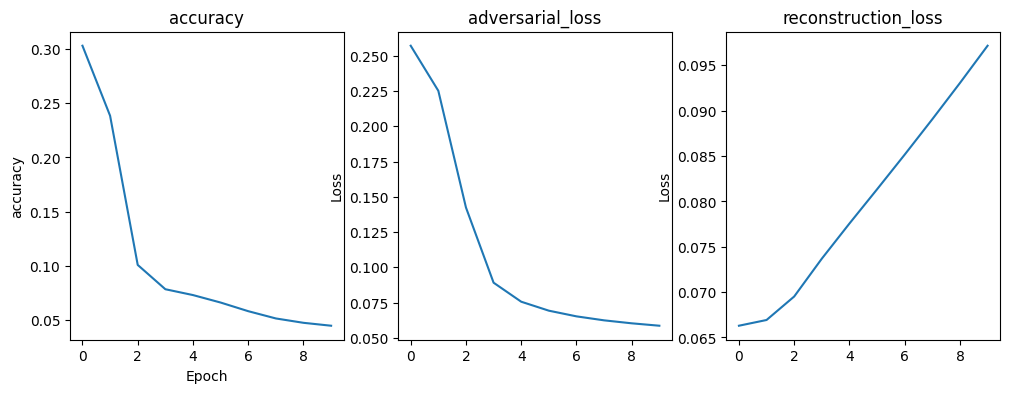

In [305]:
#--Visualisize Training---
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["accuracy"])
#plt.plot(history["reconstruction_loss"])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 3, 2)
plt.plot(history["adversarial_loss"])
plt.title('adversarial_loss')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(history["reconstruction_loss"])
plt.title('reconstruction_loss')
plt.ylabel('Loss')
plt.show